# Fraudulent Job Postings

In [1]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# sklearn
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline


#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB



#Data Evaluation 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, \
                                    cross_validate , \
                                    GridSearchCV, \
                                    cross_val_predict

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

#Mellissas utils
from utils import *

## Data Understanding

![image](https://www.bleepstatic.com/content/hl-images/2019/04/23/FBI_IC3.jpg)

Image from: [FBI](https://www.fbi.gov/contact-us/field-offices/elpaso/news/press-releases/fbi-warns-cyber-criminals-are-using-fake-job-listings-to-target-applicants-personally-identifiable-information)

-

Fake Job Description Prediction: 

This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs.

In [2]:
df = pd.read_csv('../Data/fake_job_postings.csv', index_col=0)
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


### Target
- Fraudulent

In [6]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

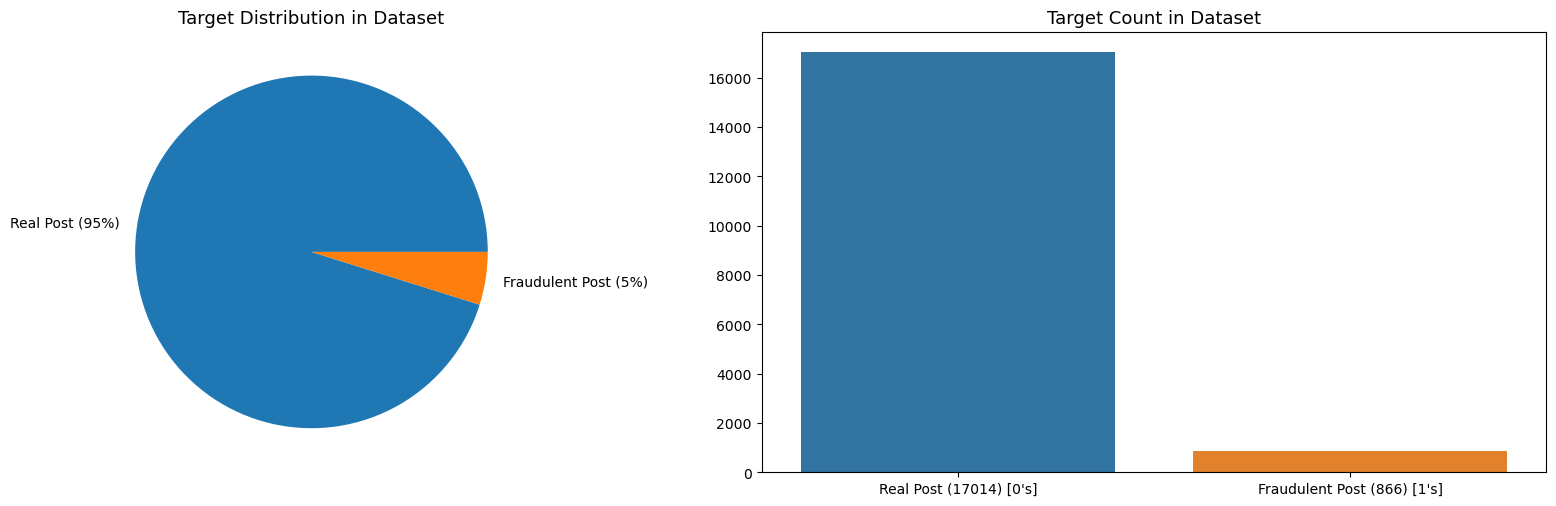

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100,)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fraudulent Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fraudulent Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

## Data Prep

- First Row

In [9]:
#
df['has_benefit'] = pd.notnull(df["benefits"])
df['has_requirements'] = pd.notnull(df["requirements"])
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


In [11]:
# Location
df['location'] = df['location'].fillna(' ')
df['location'] = df['location'].apply(lambda x: x[3:6] )
df['location'] = df['location'].replace(' , ','unknown' )

### Dealing with missing values 

In [14]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_benefit', 'has_requirements'],
      dtype='object')

In [15]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')

# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('no requirement listed')

# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('unknown')

# Fill nulls with 'no required_experience listed'
df['required_experience'] = df['required_experience'].fillna('unknown')

# Fill nulls with 'no company_profile listed'
df['company_profile' ]= df['company_profile'].fillna('unknown')

# Fill nulls with 'no companylogo'
df.has_company_logo.replace({0:"nocompanylogo",1:'hascompanylogo'},inplace=True)

 ### Combining our text data in a single column to start the cleaning  process

In [20]:
df['has_company_logo' ]

job_id
1        hascompanylogo
2        hascompanylogo
3        hascompanylogo
4        hascompanylogo
5        hascompanylogo
              ...      
17876    hascompanylogo
17877    hascompanylogo
17878     nocompanylogo
17879     nocompanylogo
17880    hascompanylogo
Name: has_company_logo, Length: 17880, dtype: object

In [21]:
# 
df['text'] = '  '+ df['title'] +'  '+ df['description'] +'  '+ df['requirements']+'  '+ \
                   df['benefits']+'  '+ df['required_experience'] + '  ' + df['has_company_logo' ] + '  ' + \
                   df['company_profile' ] + '  '
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,NY,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,hascompanylogo,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Marketing Intern Food52, a fast-growing, Ja..."
2,Customer Service - Cloud Video Production,unknown,Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,hascompanylogo,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,True,True,Customer Service - Cloud Video Production O...


In [22]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

In [23]:
actual_jobs_text

job_id
1          Marketing Intern  Food52, a fast-growing, Ja...
2          Customer Service - Cloud Video Production  O...
3          Commissioning Machinery Assistant (CMA)  Our...
4          Account Executive - Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE: Itemization ...
                               ...                        
17876      Account Director - Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer - Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we?Vend ...
Name: text, Length: 17014, dtype: object

In [24]:
fraud_jobs_text

job_id
99         IC&E Technician  IC&amp;E Technician | Baker...
145        Forward Cap.  The group has raised a fund fo...
174        Technician Instrument & Controls   Technicia...
181        Sales Executive  Sales Executive  Sales Exec...
216        IC&E Technician Mt Poso  IC&amp;E Technician...
                               ...                        
17828      Student Positions Part-Time and Full-Time.  ...
17829      Sales Associate  LEARN TO EARN AN EXECUTIVE ...
17830      Android Developer  inFullMobile Sp. z o.o. i...
17831      Payroll Clerk   JOB DESCRIPTIONWe are seekin...
17832      Furniture mover  earn $500 to $1000 a week a...
Name: text, Length: 866, dtype: object

In [25]:
actual_jobs_text.value_counts().sum()

17014

In [26]:
fraud_jobs_text.value_counts().sum()

866

## Data Cleaning

In [29]:
# only need target and text
data = df[["fraudulent", "text"]]
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


 Taken from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [32]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

## Remove punctionation and numbers, and turn lowercase

In [34]:
# Apply to the DF series
data.text = data.text.apply(remove_punctuations)

In [35]:
data.text

job_id
1          Marketing Intern  Food52  a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

In [37]:
data.text = data.text.apply(remove_number)
data.text


job_id
1          Marketing Intern  Food    a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

- All punctuations removed, next turn all lowercase


In [38]:
# All lowercase
data.text = data.text.str.lower()
# Adding State last to keep it Caps
data.text = data['text'] +'  '+ df['location']+'  '

#### WordCloud Clean

In [40]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = data[data.fraudulent==1].text
actual_jobs_text = data[data.fraudulent==0].text

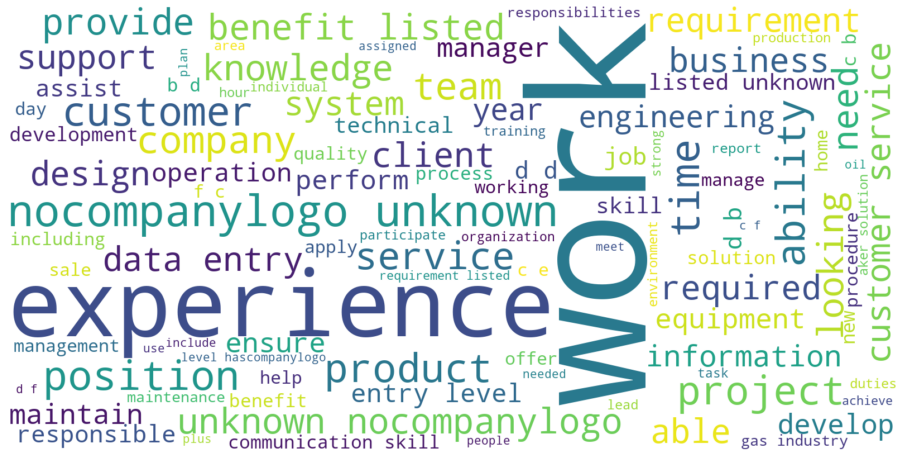

In [42]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

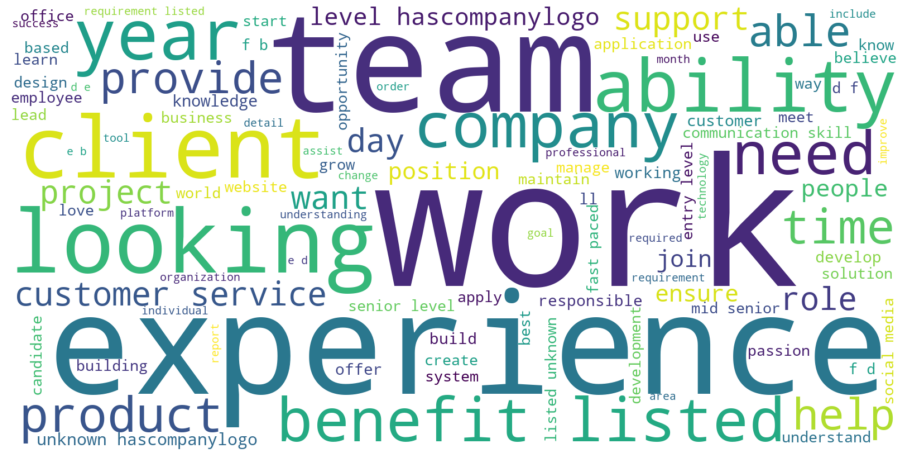

In [43]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

In [44]:
# Custom transformer 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [45]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3),lowercase=True)
bow_vector

![image](https://www.mcafeetaft.com/wp-content/uploads/scam-alert-graphic-feature-660x371.jpg)

# Machine Learning Models

In [47]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.3)

In [48]:
y_train.value_counts()

0    11933
1      583
Name: fraudulent, dtype: int64

## Baseline LogisticRegression Model

In [54]:
clf = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                # ('under',RandomUnderSampler('majority',random_state=42)),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7ff539ee50>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f8069b3e430>)),
                ('classifier', LogisticRegression())])

In [55]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9852721849366145
Logistic Regression Recall: 0.7385159010600707


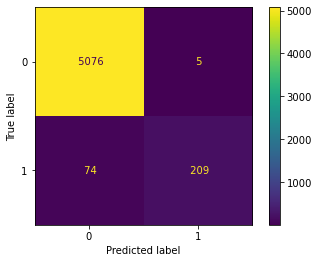

In [56]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

## Random Forest

In [57]:
clf = RandomForestClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f8055ca24c0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f8069b3e430>)),
                ('classifier', RandomForestClassifier())])

In [58]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9809843400447428
Random Forest Recall: 0.6431095406360424


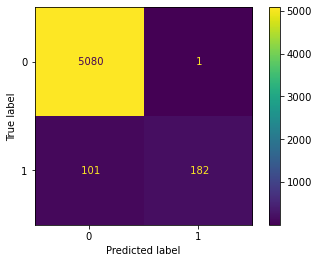

In [59]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

## XGBoost Classifier

In [60]:
clf = XGBClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f8055c07190>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f8069b3e430>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
            

In [61]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, predicted))
print("XGBoost Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.9835943325876212
XGBoost Recall: 0.7137809187279152


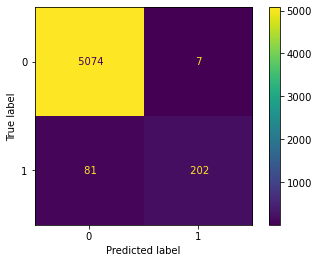

In [62]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                     # cmap='Reds', 
                      values_format=' ')


# Dealing with imbalance Oversampling

# TfidfVectorizer

In [64]:
imb_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])

imb_log_results = cross_validate(imb_log_model,X_train,y_train,return_train_score=True)

In [65]:
imb_log_preds = cross_val_predict(imb_log_model,X_train,y_train)

In [66]:
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [67]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9625279642058165
Recall: 0.8692579505300353


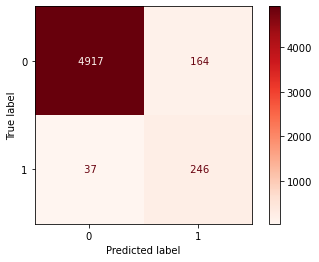

In [68]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

# bow_vector

In [69]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', bow_vector),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])

In [71]:
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f8069b3e430>)),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [72]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9852721849366145
Recall: 0.8056537102473498


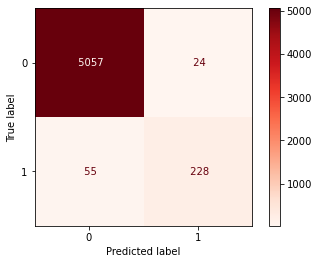

In [73]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

## CountVectorizer and over

In [74]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', CountVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])
# fitting the model
imb_log_model.fit(X_train,y_train)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [75]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9796793437733035
Recall: 0.823321554770318


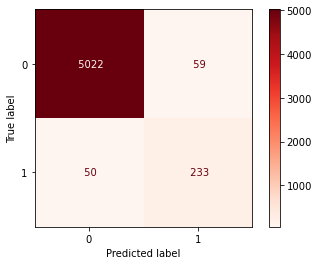

In [76]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- CountVectorizer Oversampling is our best Model.

## Undersampling 

### TfidfVectorizer

In [77]:
under_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression())])

# fitting the model
under_log_model.fit(X_train,y_train)


Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LR', LogisticRegression())])

In [78]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9366144668158091
Recall: 0.8869257950530035


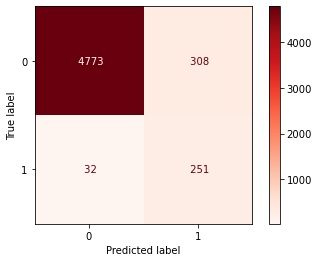

In [79]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- ouch that was pretty bad

## CountVectorizer

In [80]:
under_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression())])

# fitting the model
under_log_model.fit(X_train,y_train)



Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LR', LogisticRegression())])

In [81]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9073452647278151
Recall: 0.9293286219081273


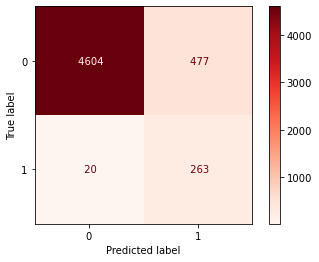

In [82]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

# Testing Indeed Dataset !!

## CountVectorizer and over

In [83]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', CountVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])
# fitting the model
imb_log_model.fit(X_train,y_train)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [84]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9796793437733035
Recall: 0.8268551236749117


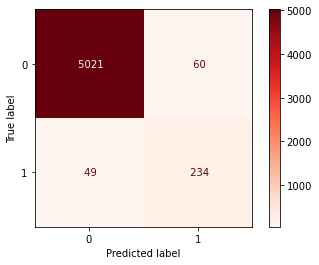

In [85]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- CountVectorizer and over looks good. We've got a winner

In [86]:
indeed = pd.read_csv('../Data/indeed', index_col=0)
indeed

,text
0,shift manager id we are lookin...
1,operations support manager id ...
2,senior product manager data id ...
3,part time office concierge id ...
4,print marketing associate id ...
...,...
29997,bilingual teller id a little a...
29998,rental consultant harrison oh id ...
29999,product support specialist id ...
30000,marketing strategist contract id ...


In [88]:
# text from indeed to predict
test = indeed.text

In [89]:
# Prediction on indeed text
y_preds_indeed = imb_log_model.predict(test)

In [90]:
# Labelling 
indeed['Label'] = pd.Series(y_preds_indeed)

In [91]:
indeed

,text,Label
0,shift manager id we are lookin...,0
1,operations support manager id ...,0
2,senior product manager data id ...,0
3,part time office concierge id ...,1
4,print marketing associate id ...,0
...,...,...
29997,bilingual teller id a little a...,0
29998,rental consultant harrison oh id ...,1
29999,product support specialist id ...,0
30000,marketing strategist contract id ...,0


In [92]:
indeed.Label.value_counts()

0    28705
1     1297
Name: Label, dtype: int64

## Indeed Predictions

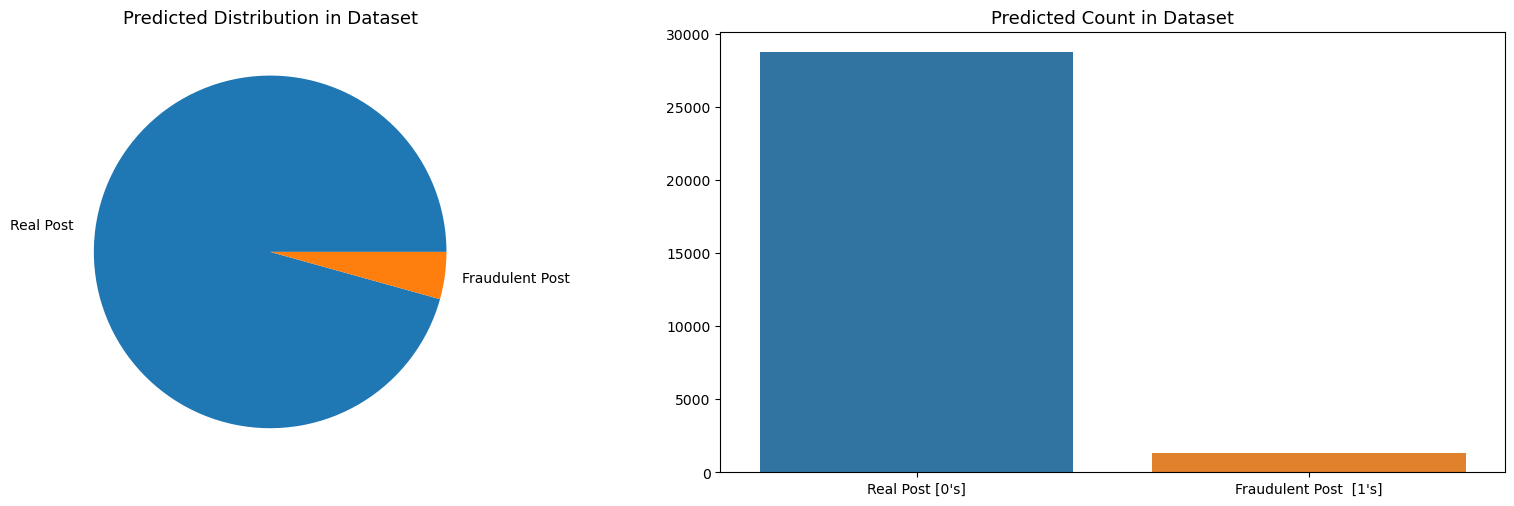

In [93]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100,)
plt.tight_layout()

indeed['Label'].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post ', 'Fraudulent Post'])
temp = indeed['Label'].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post [0's]", "Fraudulent Post  [1's]"])

axes[0].set_title('Predicted Distribution in Dataset', fontsize=13)
axes[1].set_title('Predicted Count in Dataset', fontsize=13)

plt.show()

## Labeled Predictions

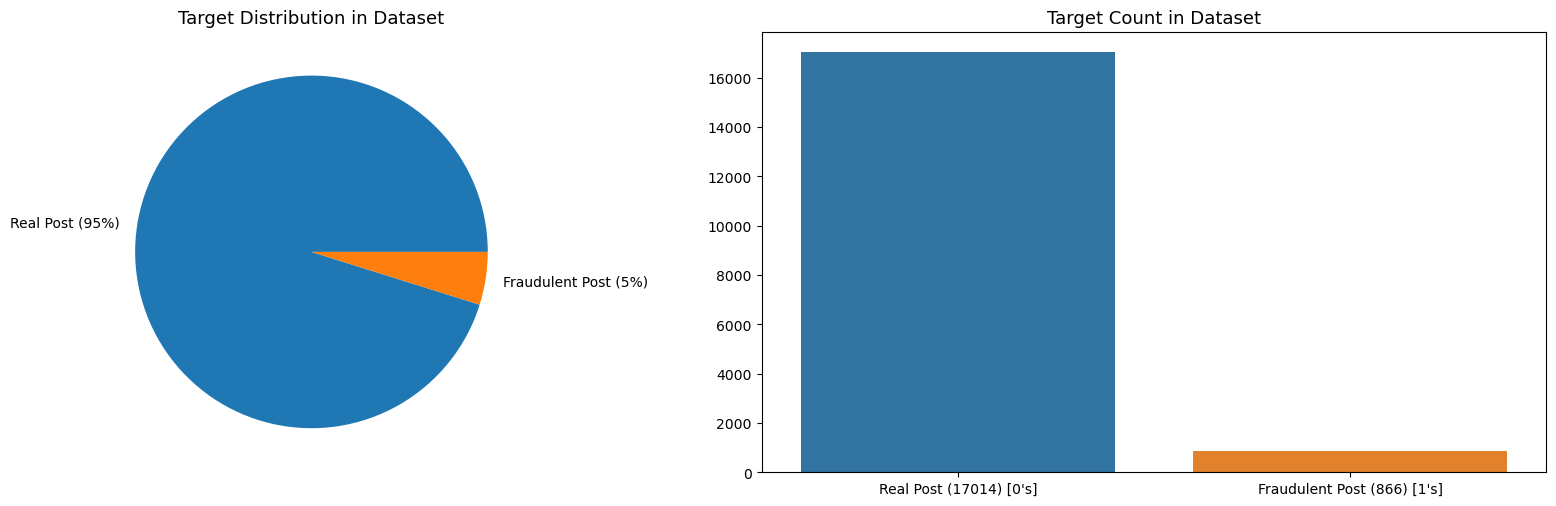

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100,)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fraudulent Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fraudulent Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()